In [1]:
# Using:
# - Python 3.8.8
# - PyTorch 1.8.1

In [2]:
# mlp for multi-output regression
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Generative model

### Data import

In [3]:
# get the dataset
def get_dataset():
    with open("data_batch_14000.json", "r") as read_file:
        data = json.load(read_file)
        
        pos = np.array(list(map(lambda x: [
            x['position']['x'],
            x['position']['y'],
            x['angle']
        ], data)))
        
                
        ranges = np.array(list(map(lambda x: x['laser_ranges'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return pos, ranges

In [4]:
pos, ranges = get_dataset()

### Data visualization

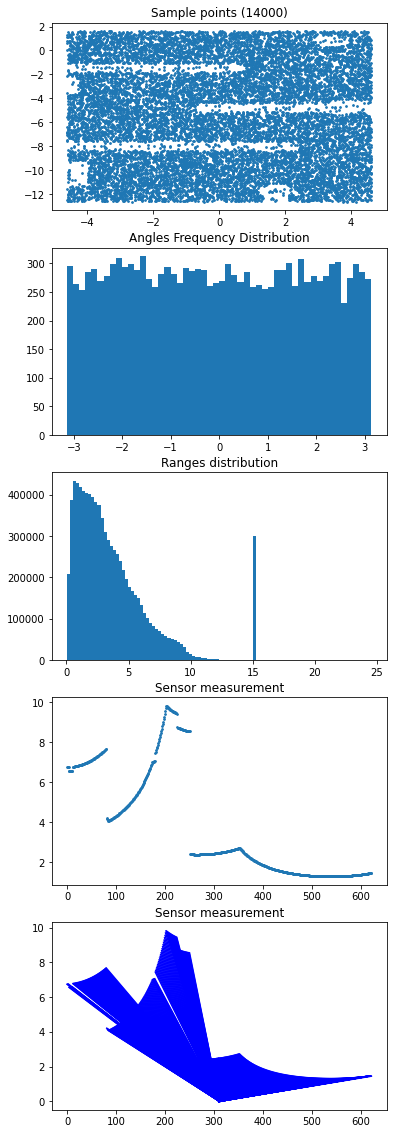

In [5]:
fig, axs = plt.subplots(5)
fig.set_figheight(20)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos[:, 0], pos[:, 1], s=3);

axs[1].set_title('Angles Frequency Distribution')
axs[1].hist(pos[:, 2], bins=50)

all_ranges = np.concatenate(ranges).ravel()
axs[2].set_title('Ranges distribution')
axs[2].hist(all_ranges, bins=100)

axs[3].set_title('Sensor measurement')
axs[3].scatter(np.arange(len(ranges[0])), ranges[0], s=3);

axs[4].set_title('Sensor measurement')
for i in range(len(ranges[0])):
    axs[4].plot([len(ranges[0])/2, i], [0, ranges[0][i]], '-b')

### Data normalization

In [6]:
def normalize_ranges(ranges_matrix):
    ranges_matrix = (ranges_matrix - ranges_matrix.min()) / (ranges_matrix.max() - ranges_matrix.min())
    return ranges_matrix
    
def normalize_pos(positions):
    positions[:, 0] = (positions[:, 0] - positions[:, 0].min()) / (positions[:, 0].max() - positions[:, 0].min())
    positions[:, 1] = (positions[:, 1] - positions[:, 1].min()) / (positions[:, 1].max() - positions[:, 1].min())
    positions[:, 2] = (positions[:, 2] - positions[:, 2].min()) / (positions[:, 2].max() - positions[:, 2].min())
    return positions

print(pos[:, 0].max(), pos[:, 0].min())

4.619 -4.617


Train data points: 11200
Test data points: 2800
Length of ranges per data point: 622


(array([1.71270e+05, 3.09063e+05, 3.49554e+05, 3.42745e+05, 3.31013e+05,
        3.27428e+05, 3.22743e+05, 3.23229e+05, 3.16342e+05, 3.05247e+05,
        2.97298e+05, 2.74097e+05, 2.48482e+05, 2.32154e+05, 2.21007e+05,
        2.12537e+05, 2.05168e+05, 1.90008e+05, 1.73118e+05, 1.56139e+05,
        1.40450e+05, 1.34583e+05, 1.26215e+05, 1.18752e+05, 1.05889e+05,
        9.03760e+04, 8.14320e+04, 7.24330e+04, 6.61060e+04, 5.97320e+04,
        5.67500e+04, 5.11420e+04, 4.64740e+04, 4.21890e+04, 4.02750e+04,
        3.76440e+04, 3.45390e+04, 3.07910e+04, 2.43870e+04, 1.49820e+04,
        1.05890e+04, 7.95500e+03, 6.21200e+03, 4.81200e+03, 3.69500e+03,
        2.84700e+03, 2.10400e+03, 1.67800e+03, 1.29000e+03, 8.51000e+02,
        5.30000e+02, 2.33000e+02, 1.03000e+02, 3.20000e+01, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 2.39639e+05, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 3.00

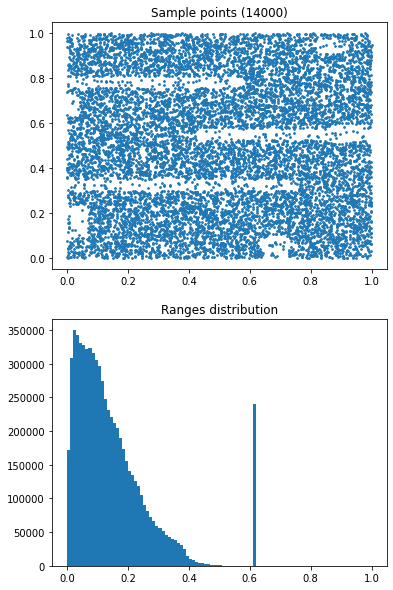

In [7]:
# Splitting dataset into test and train
dataset_size = len(pos)
train_data_percentage = 0.8
train_upto_idx = int(dataset_size * train_data_percentage)

train_pos = pos[0 : train_upto_idx]
train_ranges = ranges[0 : train_upto_idx]
test_pos = pos[train_upto_idx : dataset_size]
test_ranges = ranges[train_upto_idx : dataset_size]

print('Train data points: {length}'.format(length=len(train_pos)))
print('Test data points: {length}'.format(length=len(test_pos)))
print('Length of ranges per data point: {length}'.format(length=len(ranges[0])))


# Normalizing data
train_pos = normalize_pos(train_pos)
train_ranges = normalize_ranges(train_ranges)
test_pos = normalize_pos(test_pos)
test_ranges = normalize_ranges(test_ranges)

# Visualizing normalized data
fig, axs = plt.subplots(2)
fig.set_figheight(10)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(train_pos[:, 0], train_pos[:, 1], s=3);

axs[1].set_title('Ranges distribution')
axs[1].hist(np.concatenate(train_ranges).ravel(), bins=100)

### Transposed Convolutional Neural Network

In [8]:
class ConvTransposeNet(nn.Module):
    def __init__(self):
        super(ConvTransposeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(3, 99),
            nn.ReLU(),
            nn.Linear(99, 198),
            nn.ReLU(),
            
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=22, stride=3, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        
        
    def forward(self, x):     
        out = self.layers(x)
        
        return out

In [9]:
torch.set_default_tensor_type('torch.DoubleTensor')

# Hyperparameters
num_epochs = 10
batch_size = 2000
learning_rate = 0.003

train_tensor_dataset = TensorDataset(torch.from_numpy(train_pos).double(), torch.from_numpy(train_ranges).double())
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)

test_tensor_dataset = TensorDataset(torch.from_numpy(test_pos).double(), torch.from_numpy(test_ranges).double())
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

test_batch_pos, test_batch_ranges = next(iter(test_loader))
test_batch_pos.unsqueeze_(1)
test_batch_ranges.unsqueeze_(1)

tensor([[[0.0381, 0.0380, 0.0379,  ..., 0.2846, 0.2848, 0.2850]],

        [[0.0422, 0.0424, 0.0427,  ..., 0.1204, 0.1201, 0.1198]],

        [[0.0422, 0.0422, 0.0421,  ..., 0.1080, 0.1082, 0.1084]],

        ...,

        [[0.3579, 0.3575, 0.3570,  ..., 0.1349, 0.1350, 0.1352]],

        [[0.1602, 0.1604, 0.1607,  ..., 0.1130, 0.1122, 0.1114]],

        [[0.0460, 0.0459, 0.0458,  ..., 0.1132, 0.1132, 0.1132]]])

### Model training

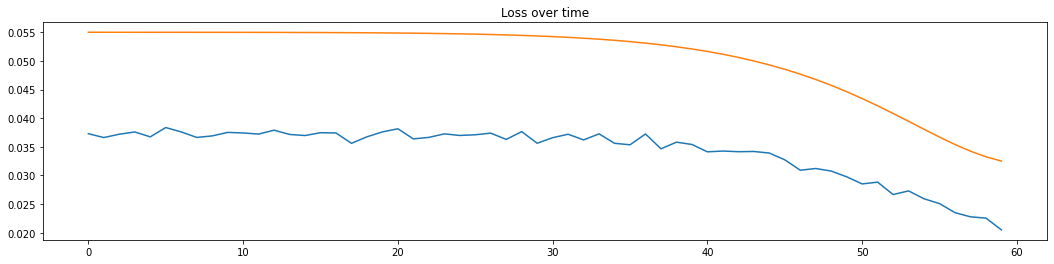

In [17]:
model = ConvTransposeNet()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    for i, (pos, ranges) in enumerate(train_loader):
        pos.unsqueeze_(1) # adds one extra dimension to make it (1, 1, 3) for the ConvTranspose1d        
        ranges.unsqueeze_(1)
        
        # Forward pass
        outputs = model(pos)
        
        # Loss computation
        loss = criterion(outputs, ranges)
        loss_list.append(loss.item())        
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # Test loss computation        
        test_outputs = model(test_batch_pos)
        test_loss = criterion(test_outputs, test_batch_ranges)
        test_loss_list.append(test_loss.item())


fig2, axs2 = plt.subplots()
fig2.set_figwidth(18)
axs2.set_title('Loss over time')
axs2.plot(np.arange(len(loss_list)), loss_list);
axs2.plot(np.arange(len(test_loss_list)), test_loss_list);

### Model performance visualization

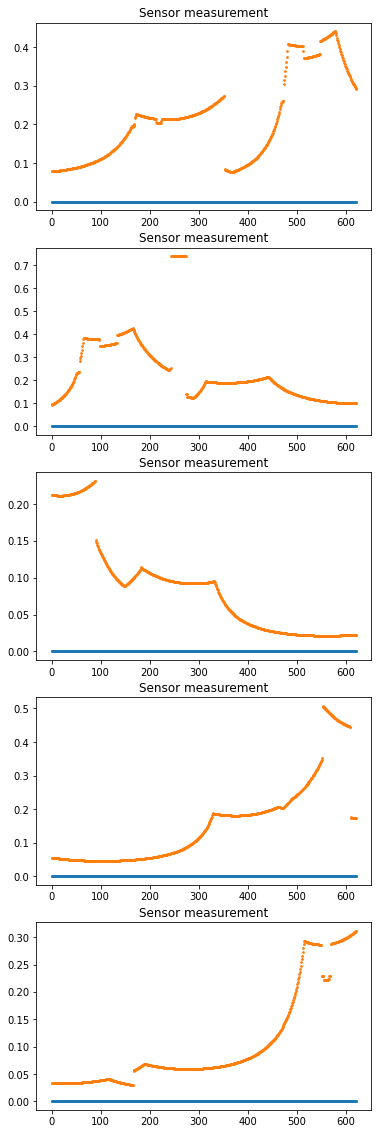

In [11]:
test_outputs = model(test_batch_pos)
test_loss = criterion(test_outputs, test_batch_ranges)


nr_plots = 5
fig3, axs3 = plt.subplots(nr_plots)
fig3.set_figheight(nr_plots * 4)

for i in range(nr_plots):
    sample_idx = random.randint(0, 999)
    single_output = test_outputs[sample_idx][0].detach().numpy()
    single_true_output = test_batch_ranges[sample_idx][0].detach().numpy()
    
    axs3[i].set_title('Sensor measurement')
    axs3[i].scatter(np.arange(len(single_output)), single_output, s=3);
    axs3[i].scatter(np.arange(len(single_true_output)), single_true_output, s=3);

# Predictive coding model

In [12]:
def fep(real_x, real_ranges, belief_x, iterations):
    data = [] # for debugging

    for i in range(0, iterations):
        # Compute the forward model - prediction from internal state to sensory space
        pred_ranges = model(belief_x)

        # Compute the prediction error (Free Energy)
        pred_error = real_ranges - pred_ranges                                          # QUESTION: use the "criterion" function from the gen. model training? (Mean Squared Error)
        # multiply error
        #backprop
        
        # Update belief 
        belief_x = ?                                                                    # QUESTION

        # Robot movement        
        real_x = real_x   # it is not moving - no change in the position

        # Data store for plotting
        data.append([
            real_x,
            belief_x,
            pred_error
        ])
    return data


sample_idx = 378   # random sample from the test set
real_x = test_batch_ranges[sample_idx][0].detach().numpy()    # real position
real_ranges = test_batch_ranges[sample_idx][0].detach().numpy()    # real measurement

belief_x = np.array([2, 2, 1.0])      # internal belief 

data = fep(real_x, real_ranges, belief_x, 1)
plot_variables(data)

SyntaxError: invalid syntax (<ipython-input-12-a5c393ae3104>, line 14)